# IMPLEMETING CIRCUS ALGORITHM
The CIRCUS algorithm is a solver of Linear Programming optimization which uses the idea of circumcenters together with
some techniques applied in the Simplex algorithm. In this notebook, I'll implement the Simplex first, then
implement the **trial version** of the CIRCUS.

In [124]:
using Plots, LinearAlgebra

Plots.PyPlotBackend()

## SIMPLEX
Let's use as example the following case:
$$
\begin{aligned}
\textrm{Maximize} \quad & x_1 + x_2 \\
\textrm{Subject to} \quad &
        -x_1 + x_2  &\leq 1\\
\quad & x_1        &\leq 3\\
\quad & x_2         &\leq 2\\
\quad & x_1,x_2     &\geq 0
\end{aligned}
$$

We then put this in the standard form by adding slack variables:
$$
\begin{aligned}
\textrm{Maximize} \quad & x_1 + x_2 \\
\textrm{Subject to} \quad &
        -x_1 + x_2 + x_3  &= 1\\
\quad & x_1 + x_4        &= 3\\
\quad & x_2 + x_5         &= 2\\
\quad & x_1,x_2,x_3,x_4,x_5     &\geq 0
\end{aligned}
$$

Therefore we have:
$$
\begin{aligned}
\textrm{Maximize} \quad & c^T {x} \\
\textrm{Subject to} \quad & Ax = b \\
\quad & x\geq 0
\end{aligned}
$$

First, we will implement the Simplex Method following the book "Understanding and Using Linear Programming".

In [641]:
A = [-1 1 1 0 0;
      1 0 0 1 0;
      0 1 0 0 1 ]
c = [1,1,0,0,0]
b = [1,3,2]
# starting basic feasible point
xo = [0,0,1,3,2];

function SimplexFromBFS(c,A,b,initial_bfs;max_iterations=100,index_bfs=[0],index_nfs = [0])
    # Initial setup
    e  = 10^-5
    B  = findall(xo .> 0+e)
    N  = findall(xo .<= 0+e)
    if size(A[:,B])[1] != size(A[:,B])[2]
        B = index_bfs
        N = index_nfs
    end
    xn = initial_bfs[N]; xb = initial_bfs[B];
    
    # Simplex pivoting iteration
    for i = 1:max_iterations
        Ab = A[:,B]; An = A[:,N]; cb = c[B]; cn = c[N]
        p  = inv(Ab)*b
        Q  = -inv(Ab)*An
        r  = (cb'*Q + cn')'
        if all(r.<= 0)
            x_final = vcat(hcat(B,p),hcat(N,zeros(length(N))))
            x_final = x_final[sortperm(x_final[:,1]),:]
            return x_final
        end
        zo = cb'*p
#         z  = zo + r'*xn
        index_in =findmax(r)[2]
        x_in = N[index_in]
        if any(Q[:,index_in] .< 0)
            coef_entering = -p./Q[:,index_in] 
            q_neg_index   = findall(Q[:,index_in] .< 0)
            index_out     =findfirst(coef_entering .== findmin(coef_entering[q_neg_index])[1])
            x_out     = B[index_out]
            B[index_out] = x_in
            N[index_in]  = x_out
        else
            
            error("Unbounded")
        end
        println(x_in,"   ",x_out)
    end
    x_final = vcat(hcat(B,p),hcat(N,zeros(length(N))))
    x_final = x_final[sortperm(x_final[:,1]),:]
    return x_final
end


SimplexFromBFS (generic function with 1 method)

In [642]:
SimplexFromBFS(c,A,b,xo)

1   4
2   5


5×2 Array{Float64,2}:
 1.0  3.0
 2.0  2.0
 3.0  2.0
 4.0  0.0
 5.0  0.0

### Degenerte example

In [453]:
A = [-1 1 1 0 ;
      1 0 0 1]
c = [0,1,0,0]
b = [0,2]
# starting basic feasible point
xo = [0,0,0,1];
SimplexFromBFS(c,A,b,xo;max_iterations=10,index_bfs=[3,4],index_nfs=[1,2])

2   3
1   4


4×2 Array{Float64,2}:
 1.0  2.0
 2.0  2.0
 3.0  0.0
 4.0  0.0

### CIRCUS 

In [747]:
function CC(S)
    # Function to calculate the circumcenter
    T1 = (S.-S[:,1])[:,2:end]
    T2 = pinv(T1' * T1) # MODIFIED THE ORIGINAL BY THE PSEUDO-INVERSE INSTEAD OF THE INVERSE. IT SEEMS TO WORK... WHY?
    T3 = diag((S.-S[:,1])[:,2:end]' * (S.-S[:,1])[:,2:end])
    cc = S[:,1] + 0.5.*T1 * T2 * T3
    return cc
end

CC (generic function with 1 method)

In [810]:
xo = [0,0]
Ag = [-1 0;0 -1;-1 1;0 1;1 0]
c = [1,1]
b = [0,0,1,2,3];
# starting basic feasible point
J = findall(Ag*xo - b .== 0) # Active restrictions
I = setdiff(1:size(Ag)[1],J) # Inactive restrictions
J_acute = Ag[J,:]*c .< 0
qtd_acute_restrictions = sum(J_acute)
if size(J)[1] - qtd_acute_restrictions == 0
    println("Basic Feasible Solution acute")
    circum = CC(Ag[J,:])
elseif qtd_acute_restrictions == 0
    println("Optimal solution!")
else
    println("BFS with objective function c")
    circum = CC(hcat(gc./norm(gc),Ag[J_acute,:]))
end

Basic Feasible Solution acute


2-element Array{Float64,1}:
 -0.5
 -0.5

In [787]:
J = findall(Ag*xo - b .== 0) # Active restrictions
I = setdiff(1:size(Ag)[1],J) # Inactive restrictions
circum = CC(Ag[J,:])
α, index_alpha = findmin(b[I] ./ (Ag[I,:]*(-circum)))
index_alpha    = I[index_alpha]
xp = xo - α*circum

2-element Array{Float64,1}:
 2.0
 2.0

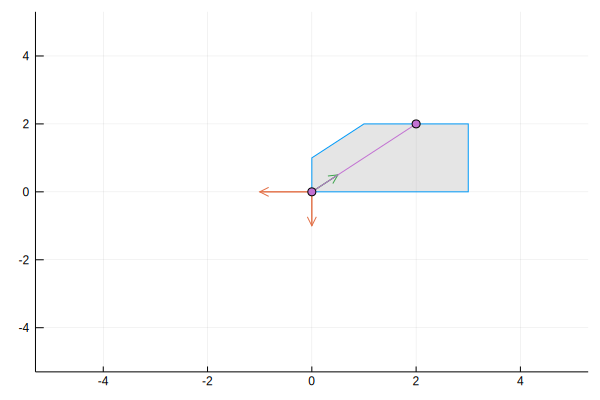

In [790]:
plot([0,0,1,3,3,0],[0,1,2,2,0,0],fill=true,fillcolor=:gray,fillalpha=0.2,legend=false)
quiver!(zeros(2),zeros(2),quiver=(Ag[1:2,1],Ag[1:2,2]),xlims=[-5,5],ylims=[-5,5])
quiver!([zeros(1)],[zeros(1)],quiver=([-circum[1]],[-circum[2]]),xlims=[-5,5],ylims=[-5,5])
plot!([xo[1],xp[1]],[xo[2],xp[2]],marker=true)

In [778]:
findmin(b[3:end] ./ (Ag[3:end,:]*(-circum)))
b[I]

3-element Array{Int64,1}:
 1
 2
 3

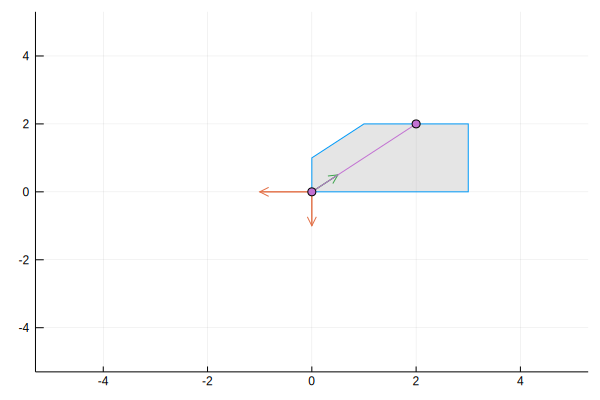

In [750]:
# α is the multiplier up to where the point hits one of the internal restrictions.
α, index_alpha = findmin(b[3:end] ./ (Ag[3:end,:]*(-circum)))
index_alpha = index_alpha + 2
# α = minimum(b[3:end] ./ (Ag[3:end,:]*(-circum)))
xp = xo - α*circum

plot([0,0,1,3,3,0],[0,1,2,2,0,0],fill=true,fillcolor=:gray,fillalpha=0.2,legend=false)
quiver!(zeros(2),zeros(2),quiver=(Ag[1:2,1],Ag[1:2,2]),xlims=[-5,5],ylims=[-5,5])
quiver!([zeros(1)],[zeros(1)],quiver=([-circum[1]],[-circum[2]]),xlims=[-5,5],ylims=[-5,5])
plot!([xo[1],xp[1]],[xo[2],xp[2]],marker=true)

In [751]:
gc = [-1,-1]
circum = CC(hcat(gc./norm(gc),Ag[index_alpha,:]))
# xo = xp
α, new_index_alpha = findmin(b[setdiff(1:end,index_alpha)] ./ (Ag[setdiff(1:end,index_alpha),:]*(-circum)))
# index_alpha = index_alpha + 2
# α = minimum(b[3:end] ./ (Ag[3:end,:]*(-circum)))
# xp = xo - α*circum
# plot([0,0,1,3,3,0],[0,1,2,2,0,0],fill=true,fillcolor=:gray,fillalpha=0.2,legend=false)
# quiver!([xp[1]],[xp[2]],quiver=([gc[1]],[gc[2]]),xlims=[-5,5],ylims=[-5,5])
# quiver!([xp[1]],[xp[2]],quiver=([Ag[index_alpha,1]],[Ag[index_alpha,2]]),xlims=[-5,5],ylims=[-5,5])
# quiver!([xp[1]],[xp[2]],quiver=([-circum[1]],[-circum[2]]),xlims=[-5,5],ylims=[-5,5])
# plot!([xo[1],xp[1]],[xo[2],xp[2]],marker=true)

(-2.0, 3)

In [754]:
Ag[setdiff(1:end,index_alpha),:][index_alpha,:]

2-element Array{Int64,1}:
 1
 0

In [690]:
index_alpha

4

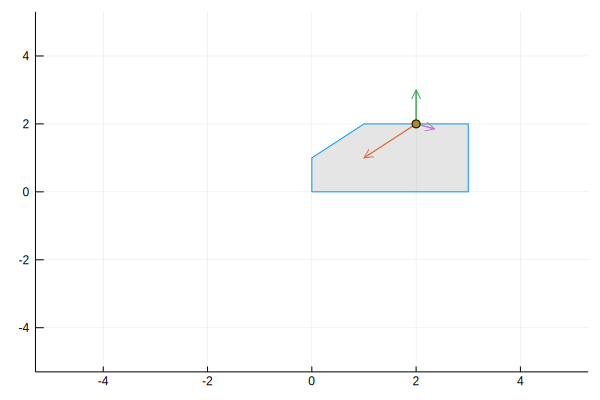

In [714]:
# Now we use the objective function
gc = [-1,-1]
circum = CC(hcat(gc./norm(gc),Ag[index_alpha,:]))
plot([0,0,1,3,3,0],[0,1,2,2,0,0],fill=true,fillcolor=:gray,fillalpha=0.2,legend=false)
quiver!([xp[1]],[xp[2]],quiver=([gc[1]],[gc[2]]),xlims=[-5,5],ylims=[-5,5])
quiver!([xp[1]],[xp[2]],quiver=([Ag[index_alpha,1]],[Ag[index_alpha,2]]),xlims=[-5,5],ylims=[-5,5])
quiver!([xp[1]],[xp[2]],quiver=([-circum[1]],[-circum[2]]),xlims=[-5,5],ylims=[-5,5])
plot!([xp[1]],[xp[2]],marker=true)